In [29]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error,
    mean_absolute_error,
)

In [30]:
# seq values 
row_count = 500
val_count = 100
test_count =100
N_LAGS =4
N_STEPS = 1

SPLIT_RATIOS = [0.80,0.10,0.10]
TRAIN_ROW_CNT = int(row_count*SPLIT_RATIOS[0])
VAL_ROW_CNT = int(row_count*SPLIT_RATIOS[1])
TEST_ROW_CNT = int(row_count*SPLIT_RATIOS[2])

val_st, val_end = TRAIN_ROW_CNT+N_LAGS, TRAIN_ROW_CNT+VAL_ROW_CNT

data=pd.DataFrame({'seq_values':np.sin(list(range(row_count))) })

for lag in range(1,N_LAGS+1):
    data[f'lag_{lag}'] = data['seq_values'].shift(lag)
data = data.dropna().reset_index(drop=True)

FEAT_COLS = [f'lag_{lag}' for lag in range(N_STEPS,N_LAGS+1)]
TGT_COLS = ['seq_values']


train_data = data.iloc[:val_st]
val_data = data.iloc[val_st:val_end]
test_data =  data.iloc[val_end:]

data.head()

,seq_values,lag_1,lag_2,lag_3,lag_4
0,-0.756802,0.141120,0.909297,0.841471,0.000000
1,-0.958924,-0.756802,0.141120,0.909297,0.841471
2,-0.279415,-0.958924,-0.756802,0.141120,0.909297
3,0.656987,-0.279415,-0.958924,-0.756802,0.141120
4,0.989358,0.656987,-0.279415,-0.958924,-0.756802


In [31]:
def get_batch_indexes(batch_size, data_len, train_len):
    total_batches = train_len//batch_size

    batch_indexes = np.column_stack((np.arange(start=0,stop=data_len, step=batch_size),
               np.arange(start=0+batch_size,stop=data_len+batch_size, step=batch_size)))
    return batch_indexes[:total_batches]

In [32]:

class EchoStateNetwork(nn.Module):
    def __init__(self, reserv_size, input_seq_len, out_len, leaky_rate, spectral_radius=0.9) -> None:
        super(EchoStateNetwork, self).__init__()

        self.W_res = torch.randn(reserv_size,reserv_size, requires_grad=False)- 0.5
        self.W_res *= spectral_radius / \
            np.max(np.abs(np.linalg.eigvals(self.W_res)))
        self.W_in = torch.randn(reserv_size,input_seq_len, requires_grad=False)- 0.5
        # W_out = nn.Parameter(torch.randn(out_len, input_seq_len+reserv_size,requires_grad=True)- 0.5)
        self.W_out = nn.Linear(in_features=input_seq_len+reserv_size, out_features=out_len)
        self.leaky_rate = leaky_rate

        # self.register_parameter(param=W_out, name='W_out')

    def forward(self, input_data, prev_res_state):
        matmul_input = torch.matmul(self.W_in,input_data)+torch.matmul(self.W_res,prev_res_state)
        x_update_n = torch.tanh(matmul_input)
        x_n = (1-self.leaky_rate)*prev_res_state + self.leaky_rate*x_update_n
        
        # print('input data:',input_data.size(),'reserv st:',x_n.size(), 'x update:',x_update_n.size(), 'matmul_input:',matmul_input.size())

        concat_tnsr = torch.concat((input_data,x_n), dim=0)
        
        # y_n = torch.matmul(self.W_out,concat_tnsr)
        # print(concat_tnsr.size())
        y_n = self.W_out(concat_tnsr.T)

        return y_n, x_n

In [39]:
RESERVOIR_SIZE = 50
model = EchoStateNetwork(reserv_size=RESERVOIR_SIZE, input_seq_len=N_LAGS, out_len=1, leaky_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

training_cost = []
validation_cost = []

for epoch in range(5):
    prev_resev_state = torch.zeros(RESERVOIR_SIZE,1)
    epoch_cost =0
    val_epoch_cost=0

    for row_num in range(TRAIN_ROW_CNT):
        row_data = train_data.iloc[row_num]
        input_data = torch.tensor(row_data[FEAT_COLS].to_list()).unsqueeze(1)
        tgt_data = torch.tensor(row_data[TGT_COLS].to_list()).unsqueeze(1)
        pred_out, prev_resev_state = model(input_data=input_data, prev_res_state=prev_resev_state)
        prev_resev_state = prev_resev_state.detach()

        cost = nn.functional.huber_loss(pred_out,tgt_data)
        if row_num%20==0:
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        epoch_cost+=float(cost.detach())

    val_prev_resev_state = torch.zeros(RESERVOIR_SIZE,1)
    for row_num in range((val_end-val_st)):
        val_row_data = val_data.iloc[row_num]
        val_input = torch.tensor(val_row_data[FEAT_COLS].to_list()).unsqueeze(1)
        val_tgt_data = torch.tensor(val_row_data[TGT_COLS].to_list()).unsqueeze(1)
        val_pred_out, val_prev_resev_state = model(input_data=val_input, prev_res_state=val_prev_resev_state)
        prev_resev_state = prev_resev_state.detach()
        val_cost = nn.functional.huber_loss(val_pred_out,val_tgt_data)
        val_epoch_cost+=float(val_cost.detach())

    epoch_cost = np.round(epoch_cost/TRAIN_ROW_CNT,4)
    val_epoch_cost = np.round(val_epoch_cost/(val_end-val_st),4)
        
    print('train cost :',epoch_cost, 'val cost:', val_epoch_cost)

    training_cost.append(epoch_cost)
    validation_cost.append(val_epoch_cost)
    

train cost : 0.0508 val cost: 0.013
train cost : 0.0071 val cost: 0.0024
train cost : 0.0008 val cost: 0.0023
train cost : 0.0004 val cost: 0.0024
train cost : 0.0003 val cost: 0.0023


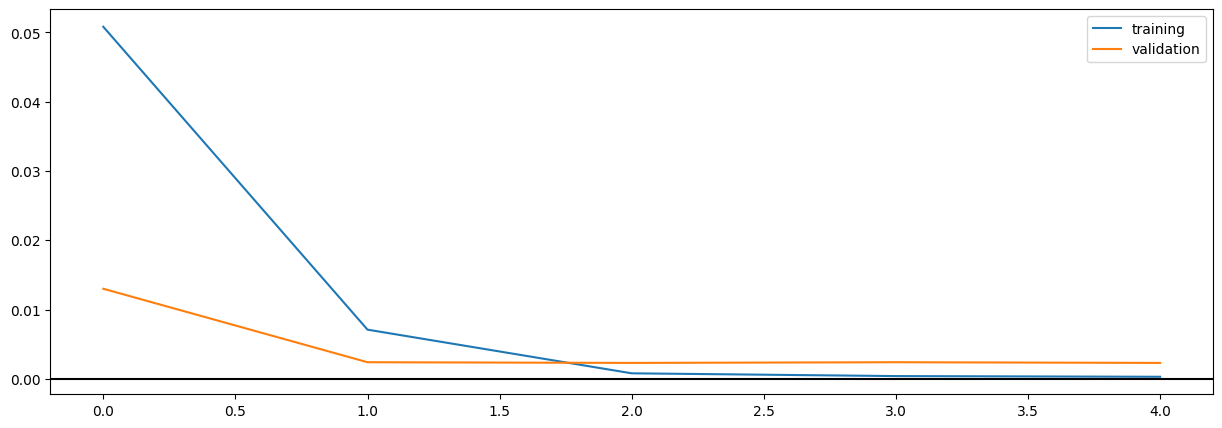

In [40]:
plt.figure(figsize=(15,5))
sns.lineplot(x=list(range(len(training_cost))) ,y=training_cost, label='training')
sns.lineplot(x=list(range(len(validation_cost))) ,y=validation_cost, label='validation')
plt.axhline(0, color='black')

C:\Users\sanja\AppData\Local\Temp\ipykernel_17180\3139102694.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['pred_val'] = trn_pred_out_lst


Text(0.5, 1.0, '1 step predictions on train data')

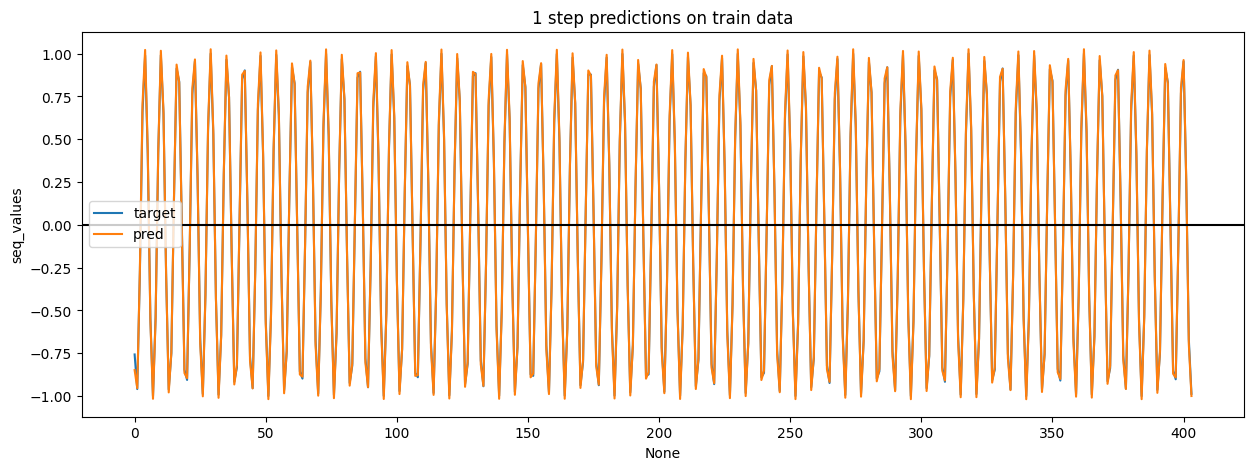

In [41]:
trn_pred_out_lst = []

prev_resev_state = torch.zeros(RESERVOIR_SIZE,1)
for row_num in range(len(train_data)):
    trn_input = torch.tensor(train_data.iloc[row_num][FEAT_COLS].to_list()).unsqueeze(1)
    trn_tgt = torch.tensor(train_data.iloc[row_num][TGT_COLS].to_list()).unsqueeze(1)
    trn_pred_out, prev_resev_state = model(input_data=trn_input, prev_res_state=prev_resev_state)
    prev_resev_state= prev_resev_state.detach()

    trn_pred_out_lst.append(trn_pred_out.detach().numpy()[0][0])

train_data['pred_val'] = trn_pred_out_lst

plt.figure(figsize=(15,5))

sns.lineplot(data=train_data,x=train_data.index, y='seq_values', label='target')
sns.lineplot(data=train_data,x=train_data.index, y='pred_val', label='pred')

plt.axhline(0, color='black')
plt.title('1 step predictions on train data')

C:\Users\sanja\AppData\Local\Temp\ipykernel_17180\3591423125.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred_val'] = test_pred_out_lst


Text(0.5, 1.0, '1 step predictions on test data')

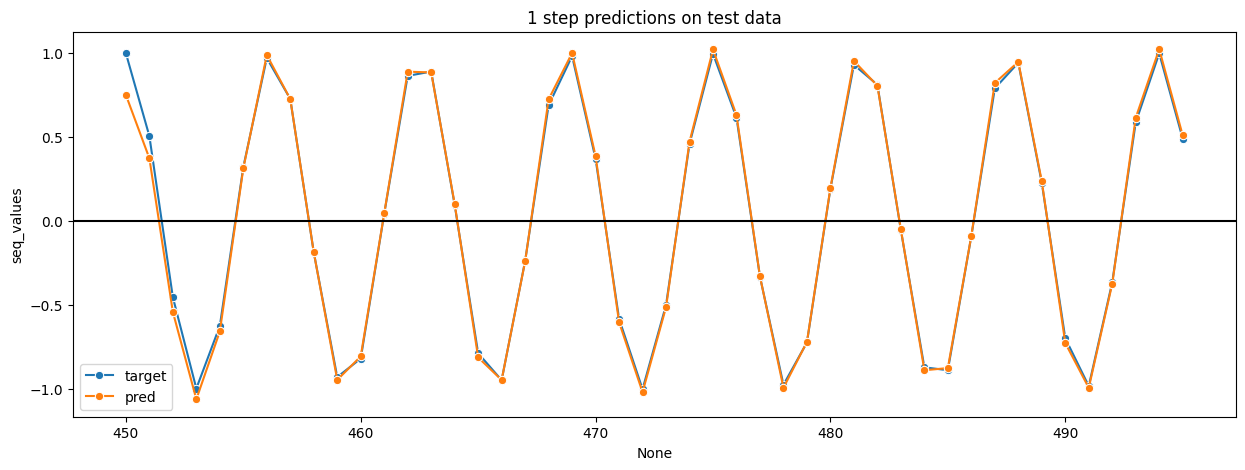

In [42]:
test_pred_out_lst = []

prev_resev_state = torch.zeros(RESERVOIR_SIZE,1)
for row_num in range(len(test_data)):
    test_input = torch.tensor(test_data.iloc[row_num][FEAT_COLS].to_list()).unsqueeze(1)
    test_tgt = torch.tensor(test_data.iloc[row_num][TGT_COLS].to_list()).unsqueeze(1)
    test_pred_out, prev_resev_state = model(input_data=test_input, prev_res_state=prev_resev_state)
    prev_resev_state= prev_resev_state.detach()

    test_pred_out_lst.append(test_pred_out.detach().numpy()[0][0])

test_data['pred_val'] = test_pred_out_lst

plt.figure(figsize=(15,5))

sns.lineplot(data=test_data,x=test_data.index, y='seq_values', label='target', marker='o')
sns.lineplot(data=test_data,x=test_data.index, y='pred_val', label='pred', marker='o')

plt.axhline(0, color='black')
plt.title('1 step predictions on test data')


In [47]:
print('train SMAPE:',mean_absolute_percentage_error(y_pred=train_data['pred_val'], y_true=train_data['seq_values'],symmetric=True))
print('test SMAPE:',mean_absolute_percentage_error(y_pred=test_data['pred_val'], y_true=test_data['seq_values'],symmetric=True))

train SMAPE: 0.033683616430412525
test SMAPE: 0.04110050067361787
